In [1]:
import os
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LC_ALL'] = 'en_US.UTF-8'
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("scipy")
sc.install_pypi_package('stop_words')
sc.install_pypi_package('TextBlob')
sc.install_pypi_package('nltk')
import matplotlib.pyplot as plt
import pandas as pd
import re
from stop_words import get_stop_words
from scipy.stats import chi2_contingency, chi2
from pyspark import sql, SparkConf, SparkContext
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.types import  * # DateType, TimestampType, ArrayType, IntegerType, DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
from collections import defaultdict
import time
import nltk

sc = SparkContext.getOrCreate()
sqlContext = sql.SQLContext(sc)
stop_words = list(get_stop_words('en')) 

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1587690280906_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)

  Using cached pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3


Processing /mnt/var/lib/livy/.cache/pip/wheels/61/13/fb/bde87253355995b963f6355ca563a614453668bfc1b44fdc54/stop_words-2018.7.23-py3-none-any.whl

  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)


In [2]:

def process_tags(string):
    tag_list = str(string).strip().split("|")
    tags = []
    for tg in tag_list: 
        clean_tg = str(tg).lower()
        for k in clean_tg.split("/"):
            k = re.sub('[^A-Za-z]+','', k)
            if (k not in stop_words) and (len(tg)>2) and not k.isnumeric():
                tags.append(k)         
    return tags

class CountryData(object):
    
    df = None
    tag_frame = None
    numeric_cols = ["views","comment_count","likes","dislikes"]
    date_cols = ["publish_time"]
    drop_cols = ["thumbnail_link","video_id","video_error_or_removed"]
    cat_cols = ["category","publish_day"]
    
    def __init__(self,file):
        self.df = sqlContext.read.csv(file, header=True)
        self.numeric()
        self.publish_time()
        self.clean_tags()
        self.process_desc()
        # self.trending_day()
        self.read_category()
        # self.classify_tags()
        
    def get_df(self):
        return self.df
    
    def get_n_rows(self,n):
        return self.df.limit(n)
    
    def schema(self):
        self.df.printSchema()
        
    def read_category(self):
        category_data=spark.read.option("multiline",True).json("s3://aws-emr-resources-337767501977-us-east-2/youtube-new/US_category_id.json")
        category_id_map=dict()
        titles=[]
        for row in category_data.collect():
            for i in range(len(row['items'])):
                category_id_map[row['items'][i]['id']]=row['items'][i]['snippet']['title']
        # print(category_id_map)
        # self.df.select("category_id").distinct().show()
        self.df = self.df.withColumn("category", F.col("category_id"))
        udf = F.UserDefinedFunction(lambda x: 'NA' if (str(x) not in category_id_map) else category_id_map[str(x)], StringType())
        self.df = self.df.withColumn('category', udf(self.df.category))
        # self.df.select("category").distinct().show()
    
    def process_desc(self):
        udf_len = F.udf(lambda x:len(x) if x is not None else 0,returnType=IntegerType())
        self.df = self.df.withColumn("num_tags",udf_len(self.df.cleaned_tags))
        self.df = self.df.withColumn("desc_length",udf_len(self.df.description))
        self.df = self.df.withColumn("title_length",udf_len(self.df.title))
        self.tag_frame = self.df.select("cleaned_tags","like_labels","dislike_labels").withColumn("exploded_tags", F.explode("cleaned_tags")).drop("cleaned_tags")
        
    
    def clean_tags(self):
        udf_func = F.udf(lambda x:process_tags(x),ArrayType(StringType()))
        # Thresholds for like and dislik labels are hardcoded using visual analysis
        like_lbl = F.udf(lambda x: 1 if ((x is not None) and (x>0.05)) else 0, IntegerType())
        dislike_lbl = F.udf(lambda x: 1 if ((x is not None) and (x>0.01)) else 0, IntegerType())
        self.df = self.df.withColumn("like_ratio",(F.col("likes")/F.col("views")).cast(DoubleType()))
        self.df = self.df.withColumn("dislike_ratio",(F.col("dislikes")/F.col("views")).cast(DoubleType()))
        self.df = self.df.withColumn("like_labels",like_lbl(self.df["like_ratio"]))
        self.df = self.df.withColumn("dislike_labels",dislike_lbl(self.df["dislike_ratio"]))
        print(self.df.agg(F.sum("like_labels")).collect()[0][0],self.df.agg(F.sum("dislike_labels")).collect()[0][0])
        self.df = self.df.fillna(0.0)
        self.df = self.df.withColumn("cleaned_tags",udf_func(self.df.tags))     
        
    def numeric(self):
        for col in self.drop_cols:
            self.df = self.df.drop(col)
        for col in self.numeric_cols:
            self.df = self.df.withColumn(col,self.df[col].cast(IntegerType()))
            self.df = self.df.fillna({col:0})
    
    def trending_day(self):
        self.df = self.df.withColumn("trending_date",self.df["trending_date"].cast(DateType()))
        self.df = self.df.withColumn("trending_day",F.date_format('trending_date','E'))
        
    def publish_time(self):
        self.df = self.df.withColumn("publish_time",self.df["publish_time"].cast(TimestampType()))
        self.df = self.df.withColumn('publish_day', F.date_format('publish_time', 'E'))
        self.df = self.df.fillna({"publish_day":"NA"})
        self.df = self.df.withColumn('publish_day_numeric', F.date_format('publish_time', 'u').astype("double"))

  


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
ca = CountryData("s3://aws-emr-resources-337767501977-us-east-2/youtube-new/USvideos.csv")
data = ca.get_df()
subset = ca.get_n_rows(200)
ca.schema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8961 598
root
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = false)
 |-- likes: integer (nullable = false)
 |-- dislikes: integer (nullable = false)
 |-- comment_count: integer (nullable = false)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publish_day: string (nullable = false)
 |-- publish_day_numeric: double (nullable = false)
 |-- like_ratio: double (nullable = false)
 |-- dislike_ratio: double (nullable = false)
 |-- like_labels: integer (nullable = true)
 |-- dislike_labels: integer (nullable = true)
 |-- cleaned_tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_tags: integer (nullable = true)
 |-- desc_length: 

In [4]:
def get_tag_score(x):
    score = 0
    if x :
        for k in x:
            sk = tagwt.get(k)
            if sk:
                score += (sk[0]-sk[1])
    return score

tags = ca.tag_frame.rdd.filter(lambda x: not(x.like_labels == 0 and x.dislike_labels == 0) )
tagwt = tags.map(lambda x: (x.exploded_tags, [x.like_labels, x.dislike_labels])).reduceByKey(lambda acc,val : (acc[0]+val[0], acc[1]+val[1]) ).collectAsMap()
udf_t = F.udf(lambda x : get_tag_score(x),IntegerType())
data = data.withColumn("tag_score",udf_t(data.cleaned_tags))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
### Trendign date is still under question So is category

m = subset["trending_date","title"]
# udf = F.udf(lambda x:datetime.strptime(x,"%y.%d.%m") if x else None, DateType())
# m = m.withColumn("new_date",udf(m.trending_date))
m = m.select(F.to_date(m.trending_date, "%yy.%mm.%dd").alias("dt"))
#print(m.columns)
m.select(F.count(F.when(F.isnan("dt"))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

when() missing 1 required positional argument: 'value'
Traceback (most recent call last):
TypeError: when() missing 1 required positional argument: 'value'



In [5]:
%%spark -o liked -n 50000
liked = data["like_ratio","dislike_ratio"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
%%spark -o categorical -n 50000
categorical = data["publish_day","category"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
%%spark -o count_based -n 50000
count_based = data["comment_count","desc_length","num_tags","title_length","tag_score"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline


def ohe_categoricals(v_df,categoricalColumns):
    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "_catIndex")
        encoder = OneHotEncoder(inputCol= categoricalCol+"_catIndex", outputCol= categoricalCol + "_classVec")
        stages += [stringIndexer, encoder]
    print(stages)
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(v_df)
    v_df = pipelineModel.transform(v_df)
    for col in v_df.columns:
        if "_catIndex" in col:
            v_df = v_df.drop(col)
    return v_df

data = ohe_categoricals(data,["publish_day","category"])
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[StringIndexer_5b9eb57d0798, OneHotEncoder_d6ff25de5e05, StringIndexer_edc17122286c, OneHotEncoder_76605b7215b6]
root
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = false)
 |-- likes: integer (nullable = false)
 |-- dislikes: integer (nullable = false)
 |-- comment_count: integer (nullable = false)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publish_day: string (nullable = false)
 |-- publish_day_numeric: double (nullable = false)
 |-- like_ratio: double (nullable = false)
 |-- dislike_ratio: double (nullable = false)
 |-- like_labels: integer (nullable = true)
 |-- dislike_labels: integer (nullable = true)
 |-- cleaned_tags: array (nullable = true)
 | 

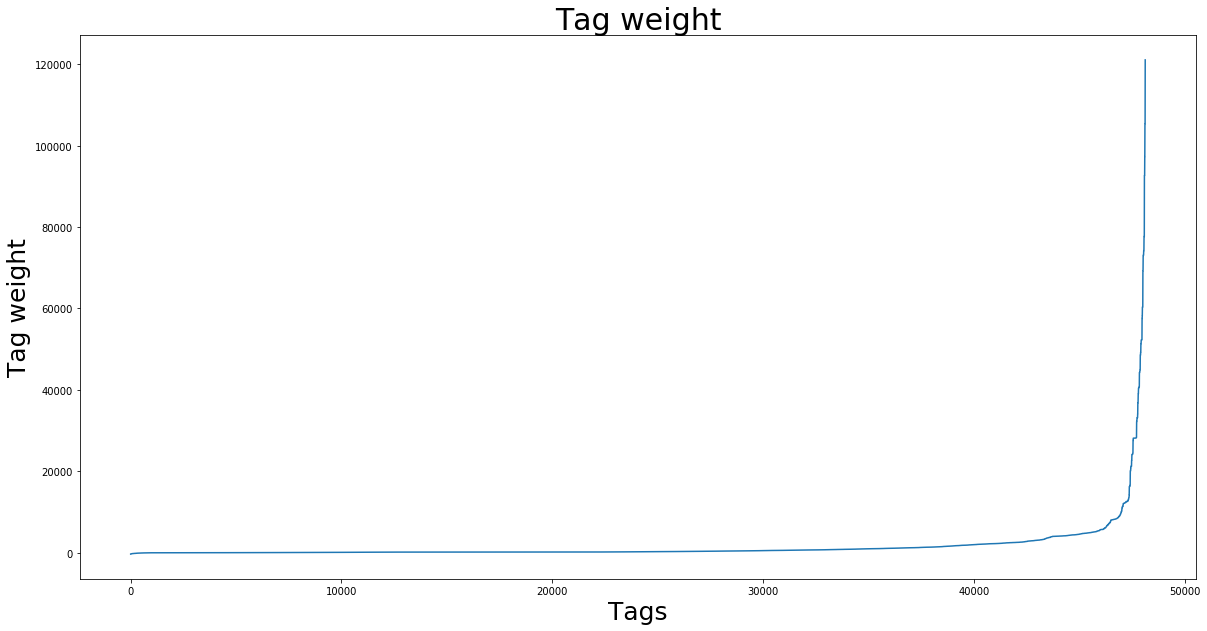

In [44]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(20,10))
# k = sorted(count_based["tag_score"].tolist())
# plt.plot(k)
# # ax.tick_params(axis="x", labelsize=25)
# # ax.tick_params(axis="y", labelsize=25)
# plt.title("Tag weight",fontsize=30)
# plt.xlabel("Tags",fontsize=25)
# plt.ylabel("Tag weight",fontsize=25)
# plt.savefig("Tag weight.png")

In [56]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(20,10))
# ax = sns.countplot(x="comment_count",data=count_based)
# ax.tick_params(axis="x", labelsize=25)
# ax.tick_params(axis="y", labelsize=25)
# plt.title("Distribution of Comment count",fontsize=30)
# plt.xlabel("Days of week",fontsize=25)
# plt.ylabel("Number of published videos",fontsize=25)
# plt.savefig("Comment_count.png")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(20,10))
# ax = sns.countplot(x="publish_day",data=categorical)
# ax.tick_params(axis="x", labelsize=25)
# ax.tick_params(axis="y", labelsize=25)
# plt.title("Days in which videos are published",fontsize=30)
# plt.xlabel("Days of week",fontsize=25)
# plt.ylabel("Number of published videos",fontsize=25)
# plt.savefig("Publish_days.png")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(20,10))
# print(categorical.columns)
# ax = sns.countplot(x="category",data=categorical)
# ax.tick_params(axis="x", rotation=90,labelsize=15)
# ax.tick_params(axis="y", labelsize=15)
# plt.title("Categories of videos",fontsize=30)
# plt.xlabel("Category name",fontsize=25)
# plt.ylabel("Number of videos",fontsize=25)
# plt.savefig("Category_count.png")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,10))
# k = sorted(liked["like_ratio"].tolist())
# plt.plot(k)
# # ax[0].tick_params(axis="x", labelsize=15)
# # ax[0].tick_params(axis="y", labelsize=15)
# plt.axhline(y=0.05,color="r",linestyle="--")
# plt.title("Generate binary labels by thresholding like/views ratio",fontsize=30)
# plt.xlabel("Video count",fontsize=20)
# plt.ylabel("Like/Views",fontsize=20)
# plt.savefig("like_ratio.png")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# %%local
# %matplotlib inline
# import matplotlib
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,10))
# print(type(liked))
# k = sorted(liked["dislike_ratio"].tolist())
# plt.plot(k)
# plt.title("Generate binary labels by thresholding dislike/views ratio",fontsize=30)
# plt.axhline(y=0.01,color="r",linestyle="--")
# plt.xlabel("Video count",fontsize=20)
# plt.ylabel("Dislikes/Views",fontsize=20)
# plt.savefig("dislike_ratio.png")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# yet to ascertain
def get_topN_freq(data, topN):
    freq_dist = nltk.FreqDist(data)
    topN_data = freq_dist.most_common(topN)
    return topN_data

def get_freq_dist_tags(df, topN):
    topN_tags = get_topN_freq(df.select("cleaned_tags").collect(),topN)
    df_topN_tags = spark.createDataFrame(topN_tags,schema = ['Word','Frequency'])
    return df_topN_tags

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df = data["category_classVec","publish_day_classVec","comment_count","likes","views","dislikes","desc_length","title_length","num_tags","like_ratio","dislike_ratio","like_labels","dislike_labels","tag_score"]
df.show(5)

ml_result_store = {}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+-------------+------+-------+--------+-----------+------------+--------+--------------------+--------------------+-----------+--------------+---------+
|category_classVec|publish_day_classVec|comment_count| likes|  views|dislikes|desc_length|title_length|num_tags|          like_ratio|       dislike_ratio|like_labels|dislike_labels|tag_score|
+-----------------+--------------------+-------------+------+-------+--------+-----------+------------+--------+--------------------+--------------------+-----------+--------------+---------+
|   (16,[5],[1.0])|       (7,[5],[1.0])|        15954| 57527| 748374|    2966|       1410|          34|       1| 0.07686931935101968|0.003963259012205128|          1|             0|        5|
|   (16,[0],[1.0])|       (7,[5],[1.0])|        12703| 97185|2418783|    6146|        630|          62|       4| 0.04017929677858659|0.002540947244957485|          0|             0|      -33|
|   (16,[4],[1.0])|       (7,[6],[1.0])|

In [92]:
import six
orderedby_corr_likes = []
orderedby_corr_dislike = []
correlation_subset = df["likes","views","dislikes","desc_length","title_length","num_tags","like_ratio","dislike_ratio","comment_count","tag_score"]
for i in correlation_subset.columns:
    if not( isinstance(correlation_subset.select(i).take(1)[0][0], six.string_types)):
        corr = correlation_subset.stat.corr('like_ratio',i)
        corr2 = correlation_subset.stat.corr('dislike_ratio',i)
        orderedby_corr_likes.append((i,corr))
        orderedby_corr_dislike.append((i,corr2))

orderedby_corr_likes = sorted(orderedby_corr_likes,key=lambda x:x[1] ,reverse=True)
orderedby_corr_dislike = sorted(orderedby_corr_dislike,key=lambda x:x[1] , reverse=True)
print(orderedby_corr_likes,orderedby_corr_dislike)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('like_ratio', 1.0), ('desc_length', 0.24338432726993875), ('likes', 0.21599549502100987), ('num_tags', 0.20406684502608025), ('comment_count', 0.15560129746576667), ('tag_score', 0.14724747604931598), ('title_length', 0.11889336985227796), ('dislike_ratio', 0.04301748426956477), ('views', 0.022990651166889028), ('dislikes', 0.021027676570961874)] [('dislike_ratio', 1.0), ('dislikes', 0.267221821536941), ('comment_count', 0.13813815647024763), ('title_length', 0.09466936475148852), ('num_tags', 0.06908403901783039), ('desc_length', 0.04556193259098116), ('like_ratio', 0.04301748426956477), ('likes', 0.028527630084238892), ('views', 0.01655073420673835), ('tag_score', -0.008746491572331665)]

In [7]:
# Linear regression setting
regr = []
def regression_run(v_df, in_feats,label):
    
    vectorAssembler = VectorAssembler(inputCols = in_feats, outputCol = 'features')
    v_df = vectorAssembler.transform(v_df)
    v_df = v_df.select(['features', label])

    splits = v_df.randomSplit([0.7, 0.3])
    train_df = splits[0]
    test_df = splits[1]
    st = time.time()
    lr = LinearRegression(featuresCol = 'features', labelCol=label ) #, maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(train_df)
    en = time.time()
    timetaken = en-st
#     print("Coefficients: " + str(lr_model.coefficients))
#     print("Intercept: " + str(lr_model.intercept))

    trainingSummary = lr_model.summary
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("R Squared (R2) on train data %f" % trainingSummary.r2 )
    
    
    lr_predictions = lr_model.transform(test_df)
    lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="like_ratio",metricName="r2")
    error = lr_evaluator.evaluate(lr_predictions)
    print("R Squared (R2) on test data = %g" % error + " Time take ",timetaken)
    regr.append([error,timetaken])
    

in_feat = []
for col in df.columns:
    if (col not in ["like_ratio","likes","like_labels","dislike_labels"]):
        in_feat.append(col)
        print("----------------------------------------------------------------------->\n")
        print(in_feat,"  ->  like_ratio",)
        regression_run(df,in_feat,"like_ratio")

ml_result_store["LR"] = regr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------------------------------------->

['category_classVec']   ->  like_ratio
RMSE: 0.022919
R Squared (R2) on train data 0.324584
R Squared (R2) on test data = 0.320351 Time take  6.296170949935913
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec']   ->  like_ratio
RMSE: 0.022713
R Squared (R2) on train data 0.327558
R Squared (R2) on test data = 0.317219 Time take  5.4474036693573
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count']   ->  like_ratio
RMSE: 0.022722
R Squared (R2) on train data 0.333957
R Squared (R2) on test data = 0.328358 Time take  5.443502902984619
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count', 'views']   ->  like_ratio
RMSE: 0.022153
R Squared (R2) on train data 0.357815
R Squared (R2) on t

In [36]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

from pyspark.ml.classification import LinearSVC

svmstore = []
def svm_classification(v_df,in_feats,out):
    vectorAssembler = VectorAssembler(inputCols = in_feats, outputCol = 'features')
    v_df = vectorAssembler.transform(v_df)
    v_df = v_df.withColumnRenamed(out,'label')
    v_df = v_df.select(['features', 'label'])
    v_df = v_df.rdd.map(lambda row: Row(row['label'], Vectors.dense(row['features']))).toDF()

    v_df = v_df.withColumnRenamed('_1','label')
    v_df = v_df.withColumnRenamed('_2','features')
    
    splits = v_df.randomSplit([0.7, 0.3])
    train_df = splits[0]
    test_df = splits[1]

    st = time.time()
    svm = LinearSVC(maxIter=5, regParam=0.01)
    model = svm.fit(train_df)
    en = time.time()
    timetaken = en-st
    test_prediction = model.transform(test_df)
    evaluator = BinaryClassificationEvaluator()
    auroc = str(evaluator.evaluate(test_prediction, {evaluator.metricName: "areaUnderROC"}))
    print("Test Area Under ROC: " + auroc + " Time : ",timetaken)
    svmstore.append([auroc,timetaken])

    
in_feat = []
for col in df.columns:
    if (col not in ["like_ratio","like_labels","likes","dislike_labels"]):
        in_feat.append(col)
        print("----------------------------------------------------------------------->\n")
        print(in_feat,"  ->  like_labels")
        svm_classification(df,in_feat,"like_labels")
    

ml_result_store["SVC"] = svmstore

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KeyboardInterrupt: 

In [8]:
from pyspark.ml.classification import RandomForestClassifier


rfstore = []
def rf_classification(v_df,in_feat,out):
    vectorAssembler = VectorAssembler(inputCols = in_feat, outputCol = 'features')
    v_df = vectorAssembler.transform(v_df)
    v_df = v_df.withColumnRenamed(out,'label')
    v_df = v_df.select(['features', 'label'])

    splits = v_df.randomSplit([0.7, 0.3])
    train = splits[0]
    test = splits[1]
    st  = time.time()
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
    rfModel = rf.fit(train)
    predictions = rfModel.transform(test)
    # predictions.show(10)
    en = time.time()
    timetaken = en-st
    # print(rfModel.featureImportances)
    evaluator = BinaryClassificationEvaluator()
    auroc = str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
    print("Test Area Under ROC: " + auroc + " Time : ",timetaken)
    rfstore.append([auroc,timetaken])
    
in_feat = []
for col in df.columns:
    if (col not in ["like_ratio","like_labels","dislike_labels","likes"]):
        in_feat.append(col)
        print("----------------------------------------------------------------------->\n")
        print(in_feat,"  ->  like_labels")
        rf_classification(df,in_feat,"like_labels")

ml_result_store["RF"] = rfstore

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------------------------------------->

['category_classVec']   ->  like_labels
Test Area Under ROC: 0.5 Time :  3.8585002422332764
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec']   ->  like_labels
Test Area Under ROC: 0.5 Time :  3.7086918354034424
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count']   ->  like_labels
Test Area Under ROC: 0.7715354002758426 Time :  4.536733627319336
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count', 'views']   ->  like_labels
Test Area Under ROC: 0.7927552805402882 Time :  4.484465837478638
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count', 'views', 'dislikes']   ->  like_labels
Test Area Under R

In [14]:
from pyspark.ml.classification import GBTClassifier
import time

gbtstore = []
def gbt_classification(v_df,in_feat,out):
    vectorAssembler = VectorAssembler(inputCols = in_feat, outputCol = 'features')
    v_df = vectorAssembler.transform(v_df)
    v_df = v_df.withColumnRenamed(out,'label')
    v_df = v_df.select(['features', 'label'])

    splits = v_df.randomSplit([0.7, 0.3])
    train = splits[0]
    test = splits[1]
    st  = time.time()
    gbt = GBTClassifier(maxIter=10)
    gbtModel = gbt.fit(train)
    en = time.time()
    predictions = gbtModel.transform(test)
    # predictions.show(10)
    timetaken = en-st
    evaluator = BinaryClassificationEvaluator()
    auroc = str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
    print("Test Area Under ROC: " + auroc + " Time : ",timetaken)
    gbtstore.append([auroc,timetaken])
    # print(gbt.explainParams())
    
in_feat = []
for col in df.columns:
    if (col not in ["like_ratio","like_labels","dislike_labels","likes"]):
        in_feat.append(col)
        print("----------------------------------------------------------------------->\n")
        print(in_feat,"  ->  like_labels")
        gbt_classification(df,in_feat,"like_labels")

ml_result_store["GBT"] = gbtstore

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-14:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2158



----------------------------------------------------------------------->

['category_classVec']   ->  like_labels
Test Area Under ROC: 0.7429162482520805 Time :  8.514883756637573
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec']   ->  like_labels
Test Area Under ROC: 0.7500240516805626 Time :  9.792064666748047
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count']   ->  like_labels
Test Area Under ROC: 0.7954600706916866 Time :  11.048828363418579
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count', 'views']   ->  like_labels
Test Area Under ROC: 0.8936545400237058 Time :  8.755707263946533
----------------------------------------------------------------------->

['category_classVec', 'publish_day_classVec', 'comment_count', 'views', 'dislikes']   ->  

In [10]:
import csv

for k in ml_result_store:
    a = ml_result_store[k]
    with open(k+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(a)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Errno 13] Permission denied: 'LR.csv'
Traceback (most recent call last):
PermissionError: [Errno 13] Permission denied: 'LR.csv'



In [15]:
for k in ml_result_store:
    for j in ml_result_store[k]:
        print(j)
    print("------------")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.32035134596187365, 6.296170949935913]
[0.31721851236581344, 5.4474036693573]
[0.3283583112506414, 5.443502902984619]
[0.35628485959503675, 4.256129264831543]
[0.3698130649219842, 4.188384294509888]
[0.3709192136630064, 4.761189937591553]
[0.38539542100363944, 5.0366857051849365]
[0.36609327735910924, 9.694073677062988]
[0.38008173615058083, 8.984099864959717]
[0.374985178969807, 14.726585865020752]
------------
['0.5', 3.8585002422332764]
['0.5', 3.7086918354034424]
['0.7715354002758426', 4.536733627319336]
['0.7927552805402882', 4.484465837478638]
['0.794729750068731', 5.30807089805603]
['0.8140453205683763', 4.9108946323394775]
['0.8023752775879675', 5.143954753875732]
['0.8443037798438497', 10.699071645736694]
['0.8301991361693793', 10.050801515579224]
['0.8516400767690903', 16.186994552612305]
------------
['0.7429162482520805', 8.514883756637573]
['0.7500240516805626', 9.792064666748047]
['0.7954600706916866', 11.048828363418579]
['0.8936545400237058', 8.755707263946533]
['0.90

In [41]:
#ca_data.select("channel_title").distinct()
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.ml.stat import ChiSquareTest
from pyspark.mllib.stat import Statistics
from itertools import chain

def perform_chi(col1,col2):
    df = ca.get_df()["category_id","publish_day_numeric"]
    print(type(df))
    print(df.head(2))
#     crosstab = ca.get_df().crosstab(col1,col2)
#     print(crosstab.count(),len(crosstab.columns))
#     print(crosstab.columns)
    # chitest = Statistics.chiSqTest(DenseMatrix(numRows=crosstab.count(), numCols=len(crosstab.columns) - 1, values=list(chain(*zip(*crosstab.drop(crosstab.columns[0]).collect())))))
    r = ChiSquareTest.test(df, "category_id","publish_day_numeric").head()
    

perform_chi("category_id","publish_day_numeric")
# df = ca.get_df()
# df.select("category_id").distinct().show()
# print(Vectors.dense(0.5, 10.0))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cannot convert type <class 'pyspark.ml.linalg.DenseMatrix'> into Vector
Traceback (most recent call last):
  File "<stdin>", line 11, in perform_chi
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/mllib/stat/_statistics.py", line 241, in chiSqTest
    jmodel = callMLlibFunc("chiSqTest", _convert_to_vector(observed), expected)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseMatrix'> into Vector



In [32]:
df.select("publish_day").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|publish_day|
+-----------+
|        Sun|
|       null|
|        Mon|
|        Thu|
|        Sat|
|        Wed|
|        Fri|
|        Tue|
+-----------+

In [5]:
pdframe = ca_data.toPandas()
kt = pd.crosstab(pdframe["channel_title"],pdframe["trending_date"])
kt.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(5153, 260)

In [8]:
kt.values.tolist()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
stat, p, dof, expected = chi2_contingency(kt.values.tolist())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
print('dof=%d' % dof)
print(expected)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

dof=1334368
[[7.26023088e-05 4.84015392e-05 4.84015392e-05 ... 4.84015392e-03
  7.26023088e-05 7.26023088e-05]
 [7.26023088e-04 4.84015392e-04 4.84015392e-04 ... 4.84015392e-02
  7.26023088e-04 7.26023088e-04]
 [7.26023088e-05 4.84015392e-05 4.84015392e-05 ... 4.84015392e-03
  7.26023088e-05 7.26023088e-05]
 ...
 [7.26023088e-05 4.84015392e-05 4.84015392e-05 ... 4.84015392e-03
  7.26023088e-05 7.26023088e-05]
 [7.26023088e-05 4.84015392e-05 4.84015392e-05 ... 4.84015392e-03
  7.26023088e-05 7.26023088e-05]
 [7.26023088e-05 4.84015392e-05 4.84015392e-05 ... 4.84015392e-03
  7.26023088e-05 7.26023088e-05]]

In [11]:
from scipy.stats import chi2
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

probability=0.950, critical=1337056.213, stat=3243647.376
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

In [10]:
ca_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: double (nullable = true)
 |-- likes: double (nullable = true)
 |-- dislikes: double (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- video_error_or_removed: string (nullable = true)
 |-- description: string (nullable = true)

In [2]:
%%local
%matplot plt 
import pyspark
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(20,10))
#def run_regression(ca_data):

plt.scatter(ca_data["views"],ca_data["likes"],color="blue",s=15)
#plt.savefig("Views_Likes.png")
plt.show()

#run_regression(ca_data)

SessionManagementException: Could not find 'session_name' session in list of saved sessions. Possible sessions are []

In [3]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest


r = ChiSquareTest.test(ca_data, "views", "likes").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1586547773285_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'ca_data' is not defined
Traceback (most recent call last):
NameError: name 'ca_data' is not defined

